In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_prod_mon_Y_agg_drop_never.csv",encoding="shift-jis",index_col=0)
df["prod_date"]

0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4194    2022-08-31
4195    2022-09-30
4196    2022-10-31
4197    2022-11-30
4198    2022-12-31
Name: prod_date, Length: 4199, dtype: object

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4194    0
4195    0
4196    0
4197    0
4198    0
Name: mon_1, Length: 4199, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_pro_agg"].replace(",","",regex=True,inplace=True)
df["rx_pro_agg"].replace(",","",regex=True,inplace=True)
# df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
# df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_pro_agg"].fillna(0,inplace=True)
df["rx_pro_agg"].fillna(0,inplace=True)
# df["stock_otc_lag"].fillna(0,inplace=True)
# df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_pro_agg"]=df["otc_pro_agg"].astype(int)
df["rx_pro_agg"]=df["rx_pro_agg"].astype(int)
# df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
# df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_pro_agg"]>0]
df=df.loc[df["rx_pro_agg"]>0]
# df=df.loc[df["stock_otc_lag"]>0]
# df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_pro_agg"]=np.log(df["rx_pro_agg"])
df["log_otc_pro_agg"]=np.log(df["otc_pro_agg"])
# df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
# df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [5]:
# change to the datetime format
df['prod_date'] = pd.to_datetime(df["prod_date"], format='%Y-%m-%d')
# df=df.set_index(["id","prod_date"])
df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2553 entries, (114, 2009) to (799, 2022)
Columns: 115 entries, month to year_trend
dtypes: datetime64[ns](1), float64(11), int32(2), int64(77), object(12), uint8(12)
memory usage: 2.0+ MB


(115, 14, 21)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [7]:
before_p=10
after_p=15
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)


+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15


                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m10        -0.1947     0.1431    -1.3603     0.1739     -0.4754      0.0860
elapsed_m9         -0.1795     0.1027    -1.7469     0.0808     -0.3809      0.0220
elapsed_m8         -0.1010     0.1313    -0.7693     0.4418     -0.3585      0.1564
elapsed_m7         -0.2255     0.1658    -1.3599     0.1740     -0.5508      0.0997
elapsed_m6         -0.0179     0.1225    -0.1465     0.8836     -0.2582      0.2223
elapsed_m5         -0.0238     0.0929    -0.2563     0.7978     -0.2059      0.1583
elapsed_m4          0.1515     0.0960     1.5775     0.1148     -0.0368      0.3398
elapsed_m3          0.0929     0.0819     1.1343     0.2568     -0.0677      0.2535
elapsed_m2          0.2016     0.1093     1.8451     0.0651     -0.0126     

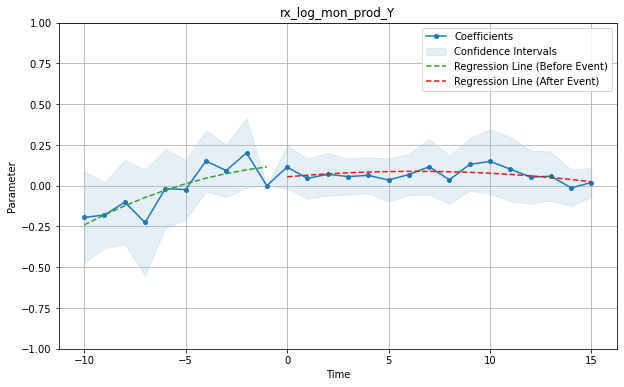

In [8]:
# take log
formula="log_rx_pro_agg ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_prod_Y",title="rx_log_mon_prod_Y",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m10         0.3272     0.2362     1.3856     0.1660     -0.1359      0.7904
elapsed_m9          0.4356     0.2698     1.6146     0.1065     -0.0934      0.9646
elapsed_m8          0.2407     0.4088     0.5888     0.5560     -0.5610      1.0424
elapsed_m7          0.0842     0.3718     0.2265     0.8208     -0.6449      0.8134
elapsed_m6         -0.2106     0.2541    -0.8288     0.4073     -0.7087      0.2876
elapsed_m5          0.0836     0.2342     0.3570     0.7211     -0.3757      0.5430
elapsed_m4          0.0607     0.2190     0.2771     0.7817     -0.3688      0.4902
elapsed_m3          0.2748     0.1964     1.3994     0.1618     -0.1103      0.6598
elapsed_m2          0.1843     0.1775     1.0388     0.2990     -0.1636     

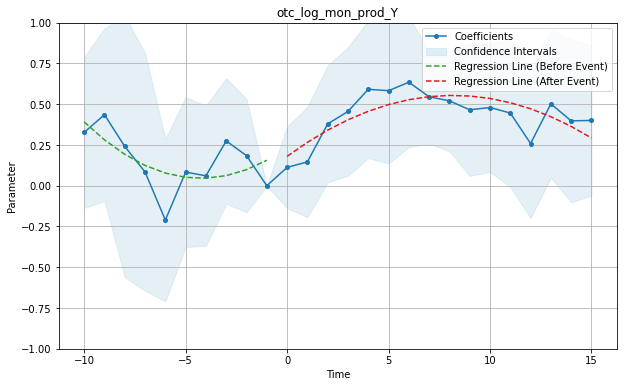

In [9]:
# take log

# till 20
# formula="log_otc_pro_agg ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_pro_agg ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_otc_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_prod_Y",title="otc_log_mon_prod_Y",ylim=(-1,1),plot_type="o-",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

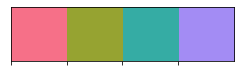

In [10]:
import seaborn as sns

# 視認性の良い4つの色を生成
colors = sns.color_palette('husl', 4)

# カラーマップを表示
sns.palplot(colors)
